In [1]:
import xgboost as xgb
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import  OneHotEncoder
from xgboost.sklearn import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time, os, random, sys
import math
import requests
from sqlalchemy import create_engine
import boto3
from boto3 import client
import logging
from collections import defaultdict,Counter
import gc

In [2]:
def typicalsampling(group,typicalNDict):
    name = group.name
    f = typicalNDict[name]
    return group.sample(frac = f)


In [5]:
typicalNDict ={
    0:0.001,
    1:0.003
}

tmp_df = pd.DataFrame()
for i in range(47):
    print(i)
    tmp = pd.read_csv('s3://',sep='|')
   
#     print(tmp.head())
    tmp_sample = tmp.groupby('label', group_keys=False).apply(typicalsampling,typicalNDict)
    tmp_df = pd.concat([tmp_df,tmp_sample],ignore_index=True)
    del tmp_sample
    gc.collect()
    

tmp_df.head()   



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46


,log_date,pid,catid1_index,catid2_index,catid3_index,list_price,discount,is_cat_male,is_cat_female,imp_1d,...,wishlist_7d_u,purchase_7d_u,atv_u,real_atv_u,real_pay_u,total_orders_u,refund_cnt_u,comment_cnt_u,cnt,label
0,2019-09-07,4298998,55,522,3561,2.93,0.79,1,0,2643,...,3,5,8.406667,8.406667,50.44,6,0,0,1,0
1,2019-09-07,3272551,20,604,4005,34.86,0.51,1,0,78589,...,0,1,4.150000,4.150000,12.45,3,0,0,1,0
2,2019-09-07,2158940,55,329,560,4.70,0.10,1,0,68350,...,2,2,5.505000,5.505000,11.01,2,0,0,1,0
3,2019-09-07,3947811,34,688,617,4.65,0.35,0,0,586,...,21,0,5.110000,5.110000,5.11,1,0,0,1,0
4,2019-09-07,2932888,55,522,606,7.02,0.55,1,0,15173,...,25,4,16.997500,17.008750,136.07,8,0,12,1,0


In [4]:
tmp_df = tmp_df.drop_duplicates()
tmp_df.shape,tmp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18800 entries, 0 to 18799
Columns: 119 entries, log_date to cnt
dtypes: float64(43), int64(75), object(1)
memory usage: 17.2+ MB


((18800, 119), None)

In [6]:
tmp_df.columns

Index(['log_date', 'pid', 'catid1_index', 'catid2_index', 'catid3_index',
       'list_price', 'discount', 'is_cat_male', 'is_cat_female', 'imp_1d',
       ...
       'wishlist_7d_u', 'purchase_7d_u', 'atv_u', 'real_atv_u', 'real_pay_u',
       'total_orders_u', 'refund_cnt_u', 'comment_cnt_u', 'cnt', 'label'],
      dtype='object', length=119)

In [14]:
res = []
for col in tmp_df.columns.tolist():
    new_dic = {}
    new_dic["name"] = str(col)
    new_dic["type"] = "Float"
    res.append(new_dic)
res[:10]

[{'name': 'log_date', 'type': 'Float'},
 {'name': 'pid', 'type': 'Float'},
 {'name': 'catid1_index', 'type': 'Float'},
 {'name': 'catid2_index', 'type': 'Float'},
 {'name': 'catid3_index', 'type': 'Float'},
 {'name': 'list_price', 'type': 'Float'},
 {'name': 'discount', 'type': 'Float'},
 {'name': 'is_cat_male', 'type': 'Float'},
 {'name': 'is_cat_female', 'type': 'Float'},
 {'name': 'imp_1d', 'type': 'Float'}]

In [16]:
with open("colname.txt", "w") as f:
    for line in res:
        f.write(str(line)+",")
        f.write('\n')#显示写入换行


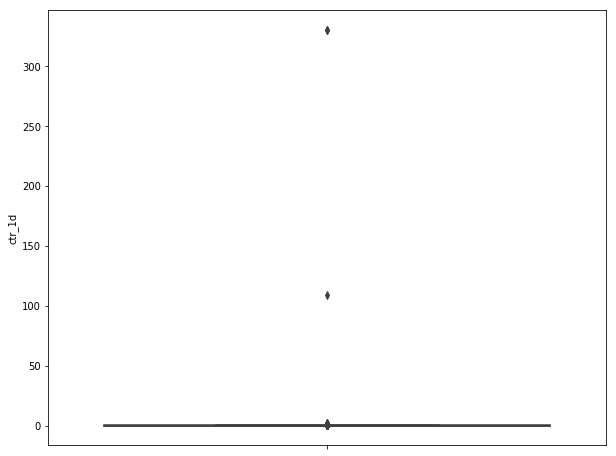

In [5]:
import seaborn as sns
f,ax=plt.subplots(figsize=(10,8))
sns.boxplot(y='ctr_1d',data=tmp_df,ax=ax)
plt.show()

In [10]:
cols = [  'imp_1d','click_1d',
          'ctr_1d','acr_1d','wr_1d',
          'sales_1d','orders_1d','buyers_1d','buyers_male_1d','buyers_female_1d',
          'buyers_neutral_1d','male_rate_1d','female_rate_1d','neutral_rate_1d',
          'imp_7d','click_7d','ctr_7d','acr_7d','wr_7d','sales_7d','sales',
          'orders_7d','orders','buyers_7d','buyers_male_7d','buyers_female_7d',
          'buyers_neutral_7d','buyers','male_rate_7d','female_rate_7d','neutral_rate_7d',
          'visit_3d_u','visit_7d_u','imp_7d_u','click_7d_u','add_7d_u','wishlist_7d_u','purchase_7d_u',
          'total_orders_u','comment_cnt_u','cnt']
for col in cols: 
    tmp_df.loc[((tmp_df[col]-tmp_df[col].mean()).abs()>3*tmp_df[col].std()),col]= np.sign(tmp_df[col])*tmp_df[col].quantile(0.5)
tmp_df.describe()

,pid,catid1,catid2,catid3,list_price,discount,is_cat_male,is_cat_female,imp_1d,imp_uv_1d,...,wishlist_7d_u,purchase_7d_u,atv_u,real_atv_u,real_pay_u,total_orders_u,refund_cnt_u,comment_cnt_u,label,cnt
count,1.880000e+04,18800.000000,18800.000000,1.880000e+04,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000,...,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000
mean,2.277920e+06,606.863298,60697.054362,4.224523e+07,8.207715,0.377036,0.345691,0.138191,36559.299309,49565.476064,...,5.915904,2.482234,9.629540,9.605550,66.692273,4.813936,0.001330,1.041596,0.387500,2.472234
std,1.272110e+06,6.922061,689.205364,2.804925e+07,10.411284,0.299285,0.475606,0.345110,44246.470827,84817.051936,...,14.797364,3.879619,10.795043,10.699141,175.987270,5.738801,0.037875,2.901943,0.487192,6.456166
min,9.175000e+03,601.000000,60101.000000,-1.000000e+00,1.050000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.155264e+06,601.000000,60130.000000,-1.000000e+00,3.060000,0.040000,0.000000,0.000000,5303.750000,4333.750000,...,0.000000,0.000000,3.405000,3.415536,6.407500,1.000000,0.000000,0.000000,0.000000,1.000000
50%,2.277475e+06,602.000000,60224.000000,6.021416e+07,5.580000,0.390000,0.000000,0.000000,22074.000000,16813.000000,...,0.000000,1.000000,6.695227,6.742500,24.300000,3.000000,0.000000,0.000000,0.000000,1.000000
75%,3.359416e+06,612.000000,61202.000000,6.120101e+07,10.250000,0.640000,1.000000,0.000000,48616.500000,57425.250000,...,4.000000,3.000000,12.540580,12.540000,65.612500,6.000000,0.000000,0.000000,1.000000,1.000000
max,4.605571e+06,647.000000,64714.000000,6.471408e+07,377.240000,1.000000,1.000000,1.000000,188265.000000,779253.000000,...,132.000000,23.000000,190.970000,190.970000,7615.720000,37.000000,2.000000,22.000000,1.000000,50.000000


In [11]:
tmp_df["label"].value_counts()

0    11515
1     7285
Name: label, dtype: int64

In [7]:
today = pd.datetime.now()

In [8]:
tmp_df["lst_visit_ts"] = tmp_df["lst_visit"].apply(lambda x: math.exp(-1.0*(today-pd.to_datetime(x)).days/30))
tmp_df["lst_add_ts"] = tmp_df["lst_add"].apply(lambda x:math.exp(-1.0*(today-pd.to_datetime(x)).days/30))
tmp_df["lst_wishlist_ts"] = tmp_df["lst_wishlist"].apply(lambda x:math.exp(-1.0*(today-pd.to_datetime(x)).days/30))
tmp_df["lst_product_buynow_ts"] = tmp_df["lst_product_buynow"].apply(lambda x: math.exp(-1.0*(today-pd.to_datetime(x)).days/30))
tmp_df["lst_cart_buynow_ts"] = tmp_df["lst_cart_buynow"].apply(lambda x:math.exp(-1.0*(today-pd.to_datetime(x)).days/30))
tmp_df["lst_buynow_ts"] = tmp_df["lst_buynow"].apply(lambda x:math.exp(-1.0*(today-pd.to_datetime(x)).days/30))

In [9]:
tmp_df.drop(['lst_visit', 'lst_add', 'lst_wishlist', 'lst_product_buynow', 'lst_cart_buynow', 'lst_buynow'], axis=1, inplace=True)
tmp_df.shape

(16779, 161)

In [12]:
tmp_df.columns

Index(['log_date', 'pid', 'catid1', 'catid2', 'catid3', 'list_price',
       'discount', 'is_cat_male', 'is_cat_female', 'imp_1d',
       ...
       'wishlist_7d_u', 'purchase_7d_u', 'atv_u', 'real_atv_u', 'real_pay_u',
       'total_orders_u', 'refund_cnt_u', 'comment_cnt_u', 'label', 'cnt'],
      dtype='object', length=119)

In [13]:
tmp_df.describe()

,pid,catid1,catid2,catid3,list_price,discount,is_cat_male,is_cat_female,imp_1d,imp_uv_1d,...,wishlist_7d_u,purchase_7d_u,atv_u,real_atv_u,real_pay_u,total_orders_u,refund_cnt_u,comment_cnt_u,label,cnt
count,1.880000e+04,18800.000000,18800.000000,1.880000e+04,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000,...,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000
mean,2.277920e+06,606.863298,60697.054362,4.224523e+07,8.207715,0.377036,0.345691,0.138191,36559.299309,49565.476064,...,5.915904,2.482234,9.629540,9.605550,66.692273,4.813936,0.001330,1.041596,0.387500,2.472234
std,1.272110e+06,6.922061,689.205364,2.804925e+07,10.411284,0.299285,0.475606,0.345110,44246.470827,84817.051936,...,14.797364,3.879619,10.795043,10.699141,175.987270,5.738801,0.037875,2.901943,0.487192,6.456166
min,9.175000e+03,601.000000,60101.000000,-1.000000e+00,1.050000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.155264e+06,601.000000,60130.000000,-1.000000e+00,3.060000,0.040000,0.000000,0.000000,5303.750000,4333.750000,...,0.000000,0.000000,3.405000,3.415536,6.407500,1.000000,0.000000,0.000000,0.000000,1.000000
50%,2.277475e+06,602.000000,60224.000000,6.021416e+07,5.580000,0.390000,0.000000,0.000000,22074.000000,16813.000000,...,0.000000,1.000000,6.695227,6.742500,24.300000,3.000000,0.000000,0.000000,0.000000,1.000000
75%,3.359416e+06,612.000000,61202.000000,6.120101e+07,10.250000,0.640000,1.000000,0.000000,48616.500000,57425.250000,...,4.000000,3.000000,12.540580,12.540000,65.612500,6.000000,0.000000,0.000000,1.000000,1.000000
max,4.605571e+06,647.000000,64714.000000,6.471408e+07,377.240000,1.000000,1.000000,1.000000,188265.000000,779253.000000,...,132.000000,23.000000,190.970000,190.970000,7615.720000,37.000000,2.000000,22.000000,1.000000,50.000000


In [14]:
train_feature = [x for x in tmp_df.columns.tolist() if x not in ["log_date","label",'pid','cid','catid1','catid2','catid3'] ]
len(train_feature)

112

In [15]:
def id_process(data,category_feature):
    # 离散特征one-hot编码
    print('开始one-hot...')
    for col in category_feature:
        onehot_feats = pd.get_dummies(data[col], prefix = col)
        data.drop([col], axis = 1, inplace = True)
        data = pd.concat([data, onehot_feats], axis = 1)
    print('one-hot结束')
    
    return data
    

In [16]:
id_feature = ['pid','cid','catid1','catid2','catid3']
tmp_df = id_process(tmp_df, id_feature)
tmp_df.shape

开始one-hot...
one-hot结束


(18800, 29366)

In [17]:
data_df = tmp_df.copy()
del tmp_df
gc.collect()

77

In [18]:
label = np.array(data_df["label"].values)
train_df = data_df.drop(["label","log_date"],axis = 1)
X_train,X_test,y_train,y_test = train_test_split(train_df,label,test_size=0.2,random_state=2019)


In [19]:
x_train = X_train[train_feature]
x_test = X_test[train_feature]
id_train = X_train.drop(train_feature,axis = 1)
id_test = X_test.drop(train_feature,axis = 1)
x_train.shape,x_test.shape,id_train.shape,id_test.shape

((15040, 112), (3760, 112), (15040, 29252), (3760, 29252))

In [29]:
def xgb_param_train(x_train,x_test,y_train,y_test):
    
    xgb1 = XGBClassifier(booster='gbtree',
                    objective= 'binary:logistic',
                    learning_rate = 0.1,
                    eval_metric='auc',
                    gamma = 0.0,
                    min_child_weight= 1,
                    max_depth= 5,
                    subsample= 0.8,
                    n_estimators=64,
                    nthread=4,
                    seed=0)
    
    def modelfit(alg,X_train,X_test,y_train,y_test,useTrainCV=True,cv_folds=5,early_stopping_rounds=100):
       
        if useTrainCV:
            xgb_param = alg.get_xgb_params()
            xgtrain =xgb.DMatrix(X_train,label=y_train)
            xgtest = xgb.DMatrix(X_test)
            cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                              early_stopping_rounds=early_stopping_rounds,show_stdv=False)
            alg.set_params(n_estimators=cvresult.shape[0])
            
        alg.fit(X_train, y_train, eval_metric='auc')
        
        dtrain_predictions = alg.predict(X_train)
        print(" Score (Train): %f" % roc_auc_score(y_train, dtrain_predictions))
        dtest_predictions = alg.predict(X_test)
        print("Score (Test): %f" % roc_auc_score(y_test, dtest_predictions))
        
    
    def paramfit(X_train,y_train):
        param_test1 = {
        'max_depth':[3,5,7],
        'min_child_weight':[1,3,5],
        'n_estimators':[32,64,80]
        }
        gsearch1 = GridSearchCV(estimator = XGBClassifier(booster='gbtree',
                    objective= 'binary:logistic',
                    learning_rate = 0.1,
                    eval_metric='auc',
                    gamma = 0.0,
                    min_child_weight= 1,
                    max_depth= 5,
                    subsample= 0.8,
                    n_estimators=64,
                    nthread=4,
                    seed=0),
                    param_grid = param_test1,n_jobs=4,iid=False, cv=5)
        gsearch1.fit(X_train,y_train)
        print(gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_)
        
    modelfit(xgb1,x_train,x_test,y_train,y_test)
    paramfit(x_train,y_train)


In [30]:
%%time
xgb_param_train(x_train,x_test,y_train,y_test)

 Score (Train): 0.717849
Score (Test): 0.668934
{'mean_fit_time': array([ 7.07629328, 15.16528883, 18.81612816,  7.28627958, 15.24922328,
       18.70642114,  7.48101597, 15.22221847, 18.49180694, 14.18063769,
       29.55171847, 36.66150656, 13.56809163, 28.06907096, 35.05463662,
       13.20419669, 27.56748452, 34.66344347, 25.0783113 , 52.36446195,
       65.52669182, 23.94511433, 47.42671242, 60.63759274, 23.11599779,
       46.14584837, 42.75298872]), 'std_fit_time': array([ 0.73078743,  0.87515548,  0.91504558,  0.55226093,  0.63974314,
        0.81141135,  0.15893738,  0.44602605,  0.98290362,  0.28651968,
        0.7487257 ,  1.34957706,  0.35253651,  0.82116003,  1.07074029,
        0.96835202,  0.77586028,  0.70689317,  0.60562603,  1.1996129 ,
        2.34273953,  0.55017958,  1.9353582 ,  1.96607056,  0.37473446,
        1.00046787, 18.51089378]), 'mean_score_time': array([0.03660035, 0.03020339, 0.0300528 , 0.039676  , 0.04085498,
       0.03785253, 0.03078852, 0.04234276,

In [20]:
def xgb_train(x_train,x_test,y_train,y_test):
    
    train_data = pd.concat([x_train,x_test],ignore_index=True)
    
    xgtrain = xgb.DMatrix(x_train,label=y_train)
    xgtest = xgb.DMatrix(x_test)
    xgball = xgb.DMatrix(train_data)
    
    xgb1 = XGBClassifier(booster='gbtree',
                    objective= 'binary:logistic',
                    learning_rate = 0.1,
                    eval_metric='auc',
                    gamma = 0.0,
                    min_child_weight= 1,
                    max_depth= 5,
                    subsample= 0.8,
                    n_estimators=64,
                    nthread=4,
                    seed=0)
    
    xgb_model = xgb.train(xgb1.get_params(),xgtrain,num_boost_round=100)
    
    print('画特征重要性排序...')
    f,ax=plt.subplots(figsize=(10,8))
    ax = xgb.plot_importance(xgb_model, max_num_features=20, height=0.5,ax=ax)#max_features表示最多展示出前20个重要性特征，可以自行设置
    plt.show()

    print('Start predicting...')
    
    all_leaves = xgb_model.predict(xgball, pred_leaf=True)
    xgbenc = OneHotEncoder()
    xgbenc.fit(all_leaves)
    
     
    train_leaves = xgb_model.predict(xgtrain, pred_leaf=True)

    print(np.array(train_leaves).shape)
    print(train_leaves[0])
    
    print('Writing transformed training data')
    transformed_training_matrix = xgbenc.transform(train_leaves).toarray() # N * num_tress * num_leafs    
    
    test_leaves = xgb_model.predict(xgtest, pred_leaf=True)

    print(np.array(test_leaves).shape)
    print(test_leaves[0])
  
    print('Writing transformed testing data')
    transformed_testing_matrix = xgbenc.transform(test_leaves).toarray() # N * num_tress * num_leafs 
    
    return transformed_training_matrix, transformed_testing_matrix,y_train,y_test

画特征重要性排序...


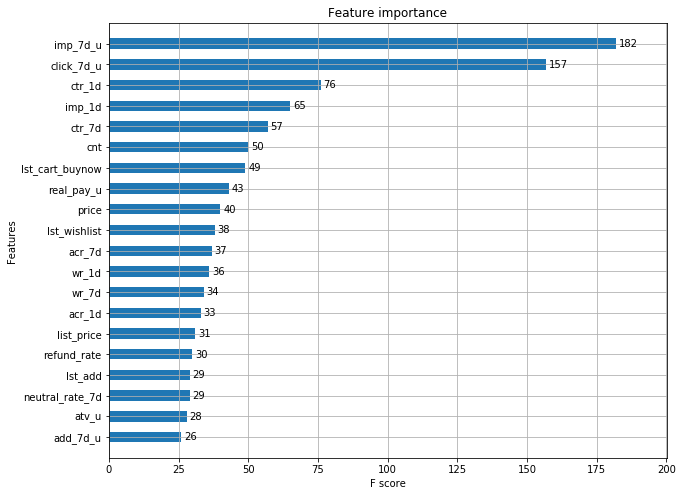

Start predicting...


/home/ec2-user/.local/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(15040, 100)
[19 19 18 17 23 20 17 17 17 16 17 17 20 21 19 19 18 22 17 23 17 29 17 20
 18 15 17 20 23 17 19 18 22 18 18 23 23 17 19 16 18 17 17 33 13 22 20 31
 26 45 21 33 38 31 35 21 18 46 31 21 31 53 37 33 30 57 31 32 25 31 19 31
 51 35 23 34 23 23 31 29 41 31 31 26 33 33 29 29 43 33 39 19 43 35 31 19
 34 34 49 26]
Writing transformed training data
(3760, 100)
[21 27 19 23 31 21 27 18 18 19 18 18 22 27 21 24 19 27 19 25 29 17 17 20
 18 25 17 20 23 17 24 26 25 20 11 31 30 18 19 20 19 18 18 45 15 23 20 44
 26 41 26 34 56 31 55 20 18 45 31 20 31 31 27 35 29 47 35 30 27 42 25 31
 47 37 24 34 24 23 36 29 35 32 31 26 39 33 29 29 46 42 30 20 33 35 31 19
 38 33 52 25]
Writing transformed testing data


In [21]:
# cat_feature = ['is_cat_male','is_cat_female','coupon_sensitive','is_country_in','is_country_me','is_country_us',
#                'is_male','is_female','is_ios']
transformed_training_matrix,transformed_testing_matrix,y_train,y_test = xgb_train(x_train,x_test,y_train,y_test)

In [22]:
transformed_training_matrix[0],transformed_training_matrix.shape

(array([0., 0., 0., ..., 0., 0., 0.]), (15040, 2057))

In [19]:
id_train.values[0],id_train.values.shape

(array([0, 0, 0, ..., 0, 0, 0], dtype=uint8), (6692, 14634))

In [23]:
transformed_training_matrix = np.hstack([transformed_training_matrix,id_train.values])
transformed_training_matrix.shape

(15040, 31309)

In [24]:
transformed_testing_matrix = np.hstack([transformed_testing_matrix,id_test.values])
transformed_testing_matrix.shape

(3760, 31309)

In [25]:
del data_df
del id_test
del id_train
gc.collect()

4799

In [25]:
y_test[-5:]

array([1, 0, 1, 0, 0])

In [26]:
def lr_train(transformed_training_matrix,transformed_testing_matrix,y_train,y_test):
    
    c = np.array([1,0.5,0.1,0.05,0.01,0.005,0.001])
    for t in range(0,len(c)):
        lm = LogisticRegression(penalty='l2',C=c[t]) 
        lm.fit(transformed_training_matrix,y_train)  
        y_pred_test = lm.predict_proba(transformed_testing_matrix)   

        NE = (-1) / len(y_pred_test) * sum(((1+y_test)/2 * np.log(y_pred_test[:,1]) +  (1-y_test)/2 * np.log(1 - y_pred_test[:,1])))
        print("Normalized Cross Entropy " + str(NE))

        auc_score = roc_auc_score(y_test, y_pred_test[:, 1])
        print('id_auc_score:', auc_score)

In [27]:
lr_train(transformed_training_matrix,transformed_testing_matrix,y_train,y_test)

/home/ec2-user/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Normalized Cross Entropy 1.356222981771601
id_auc_score: 0.7309838171749957


/home/ec2-user/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Normalized Cross Entropy 1.2426580111633592
id_auc_score: 0.7340403180358287


/home/ec2-user/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Normalized Cross Entropy 1.0486784891113878
id_auc_score: 0.7435424117806413


/home/ec2-user/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Normalized Cross Entropy 0.9872465672649939
id_auc_score: 0.7484058124775925


/home/ec2-user/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Normalized Cross Entropy 0.8888881062638416
id_auc_score: 0.7592880403377051


/home/ec2-user/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Normalized Cross Entropy 0.8624198672801792
id_auc_score: 0.7625218635476212


/home/ec2-user/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Normalized Cross Entropy 0.8202866381694536
id_auc_score: 0.7638426915327237
